# Лабораторная работа 4. Подбор гиперпараметров. Калибровка. Работа с текстовыми данными. Библиотека Vowpal Wabbit.

Постарайтесь оформить всю работу как один монолитный рассказ/отчет. Избегайте дублирования кода. Избегайте использования циклов, вместо этого ищите готовый алгоритм в пакетах. Подписывайте все графики, а также их оси, если график содержит несколько кривых, то обязательно пользуйтесь легендой. Также неукоснительно соблюдайте PEP8. За несоблюдение этих простейших правил итоговые баллы могут быть снижены безапелляционно.

In [1]:
import warnings
warnings.filterwarnings("ignore")

## 1. (5 баллов) Подбор гиперпараметров. Случайный поиск по сетке

Вы уже знаете, что для подбора гиперпараметров есть способ перебора по сетке. Обычно перебор некоторых значений гиперпараметров ведется по логарифмической шкале, так как это позволяет быстрее определить какого порядка должен быть параметр, и в то же время значительно уменьшить время поиска. Последний нюанс бывает особо критичен, так как для каждого фиксированного набора гиперпараметров происходит новое обучение алгоритма и оценка качества. 

Однако такой подход к нахождению гиперпараметров является не единственным возможным. Рассмотрим более подробно в чем может заключаться недостаток предыдущего подхода. Допустим, вам нужно подобрать 2 гиперпараметра, для каждого из которых есть сетка из 4 возможных значений. То есть всего 16 итераций обучения по сетке. Допустим также, что для оценки качества используется 5-fold CV. В итоге алгоритм будет обучен 80 раз, что уже немало. А если, например, рассмотреть случайный лес, где гиперпараметрами могут являться критерий ветвления, максимальная глубина деревьев, минимальное число объектов в листьях, максимальное число признаков, количество листьев и так далее, может получиться экспоненциально большое число обучений алгоритма, что займёт очень много времени. Для того чтобы как-то ускорить процесс и в то же время найти близкие к оптимальным значения используют **случайный** поиск по сетке. В этом случае для каждого гиперпараметра задается распределение, из которого выбираются его значения. И так как каждый раз значение каждого гиперпараметра выбирается случайно, это позволяет находить оптимум быстрее. 

Сравнение обычного поиска по сетке со случайным можно проиллюстрировать следующим образом:

![](./static/random_layout.jpeg)

Более детально о случайном поиске по сетке можно прочесть по следующим ссылкам:
 - теоретический анализ случайного поиска [Random Search for Hyper-Parameter Optimization](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf)
 - кратко и с юмором [Smarter Parameter Sweeps (or Why Grid Search Is Plain Stupid)](https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881#.pkwq17od8)
 
В sklearn случайный поиск по сетке реализован в классе [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV).

При выполнении этой части задания будем использовать [набор данных](http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) с информацией о клиентах банка и их платежах.

Загрузите данные из файла `credit_card_clients.csv` и разбейте на обучающее и тестовое множество в отношении 4 к 1.

In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("./data/credit_card_clients.csv", sep="\t", encoding="utf-8", index_col="ID")
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
y = df["default payment next month"].values
del df["default payment next month"]
X = df.values

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1968)

**(3 балла) Задание 1.**

Целью данного задания является сравнение описанных выше подходов подбора гиперпараметров на практике. А именно, посмотрим как ведет себя обычный и случайный поиск по сетке при одинаковом числе операций (бюджете). Попробуем найти оптимальные гиперпараметры для SVM с линейным ядром. В данном случае нам будет интересно найти значения у двух гиперпараметров: коэффициент регуляризации *C* и количество итераций *max_iter*. Для обоих гиперпараметров возьмите логарифмическую шкалу (см. функцию [logspace](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.logspace.html)), для *C* от 0.1 до 100, для *max_iter* от 1000 до 10000. В качестве оптимизируемой метрики качества выберем *AUC-ROC*.

 - Для обычного поиска по сетке ([GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)) подготовьте 5 сеток гиперпараметров, так чтобы каждый у каждого гиперпараметра перебиралось 2, 3, 4, 5 и 6 значений в соответствующей сетке. Таким образом у вас получится 5 запусков поиска параметров с бюджетом 4, 9, 16, 25, 36. 

 - Для случайного поиска ([RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)) сделайте 5 запусков поиска гиперпараметров с бюджетом 4, 9, 16, 25, 36. 

 - Для каждого из запусков алгоритма подбора гиперпараметров (одного — обычной и 5 для случайного) вычислите наилучшее достигнутое качество для каждого бюджета. После чего постройте график, где по оси OX будет отложен бюджет, а по оси OY — наилучшее качество.
 
Данная часть лабораторной работы может работать значительное время. Поэтому рекомендуем обратить внимание на параметр `n_jobs` поиска по сетке (есть у обоих классов). Также зафиксируйте `random_state` при использовании класса RandomizedSearchCV.

_1.1. Создаём экземпляр SVC и генерируем сетку_

In [7]:
from sklearn.svm import SVC
from sklearn.base import clone

In [8]:
svc = SVC(kernel="linear")

In [9]:
def gen_grid(n_param):
    return {
        "C": np.logspace(-1, 2, n_param),
        "max_iter": np.logspace(3, 4, n_param)
    }

_1.2. GridSearchCV_

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
grids = []
grid_scores = []
n_params = [2, 3, 4, 5, 6]

In [12]:
grid = GridSearchCV(
    svc,
    param_grid={},
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [13]:
for n_param in n_params:
    grids.append(clone(grid))
    grids[-1].set_params(param_grid=gen_grid(n_param))
    grids[-1].fit(X_train, y_train)
    grid_scores.append(grids[-1].best_score_)
    print("End of fitting GridSearchCV, n_param={}".format(n_param))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   17.6s finished


End of fitting GridSearchCV, n_param=2
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   25.3s finished


End of fitting GridSearchCV, n_param=3
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   41.5s finished


End of fitting GridSearchCV, n_param=4
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.1min finished


End of fitting GridSearchCV, n_param=5
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.7min finished


End of fitting GridSearchCV, n_param=6


_1.3. RandomizedSearchCV_

In [14]:
from sklearn.model_selection import RandomizedSearchCV

In [15]:
rgrids = []
rgrid_scores = []
n_budgets = np.array(n_params) ** 2

In [16]:
rgrid = RandomizedSearchCV(
    svc,
    param_distributions=gen_grid(6),
    n_iter=10,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    random_state=1968,
    verbose=1
)

In [17]:
for n_budget in n_budgets:
    rgrids.append(clone(rgrid))
    rgrids[-1].set_params(param_distributions=gen_grid(n_budget))
    rgrids[-1] = rgrids[-1].fit(X_train, y_train)
    rgrid_scores.append(rgrids[-1].best_score_)
    print("End of fitting RandomizedSearchCV, n_budget={}".format(n_budget))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.8s finished


End of fitting RandomizedSearchCV, n_budget=4
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.1s finished


End of fitting RandomizedSearchCV, n_budget=9
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.4s finished


End of fitting RandomizedSearchCV, n_budget=16
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.9s finished


End of fitting RandomizedSearchCV, n_budget=25
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.8s finished


End of fitting RandomizedSearchCV, n_budget=36


_1.4. Результаты_

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

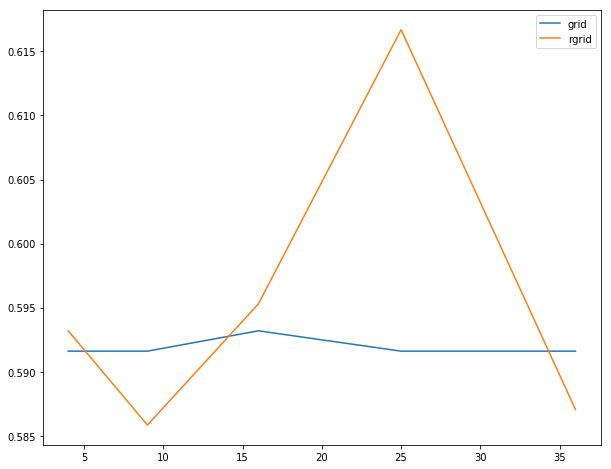

In [19]:
plt.figure(figsize=(10, 8))
plt.plot([4, 9, 16, 25, 36], grid_scores, label="grid")
plt.plot([4, 9, 16, 25, 36], rgrid_scores, label="rgrid")
plt.legend(loc="best")
plt.show()

**(2 балла) Задание 2.**

Сравните полученные графики для разных способов подбора гиперпараметров:
 * Посмотрите на наилучшие гиперпараметры, которые у вас получились. Можно ли сказать, что какой-то из гиперпараметров больше влияет на результат?

In [20]:
ind = grid_scores.index(max(grid_scores))
print("GridSearchCV:\n\t- best score: {:.5f}\n\t- best params: {}".format(grids[ind].best_score_,
                                                                         grids[ind].best_params_))

GridSearchCV:
	- best score: 0.59319
	- best params: {'C': 1.0, 'max_iter': 10000.0}


In [21]:
rind = rgrid_scores.index(max(rgrid_scores))
print("RandomizedSearchCV:\n\t- best score: {:.5f}\n\t- best params: {}".format(rgrids[rind].best_score_,
                                                                         rgrids[rind].best_params_))

RandomizedSearchCV:
	- best score: 0.61669
	- best params: {'max_iter': 2610.157215682536, 'C': 42.169650342858226}


* Можно ли сделать вывод, что случайный поиск проигрывает или же наоборот?

_В итоге у нас получилось, что случайный поиск выиграл. Вместе с этим надо отметить, что, хоть в среднем он и показывал лучшие результаты, он более нестабилен._

* Зависит ли ответ на предыдущий вопрос от размера бюджета и удачной инициализации?

_В общем-то, не очень — в целом рандомизированный перебор часто выигрывал._

## 2. (8 баллов) Калибровка классификатора

Рассмотрим в задачу, где целевой метрикой является *logloss*. Как было сказано выше, в этом случае необходимо, чтобы классификатор умел предсказывать вероятность принадлежности к классу. К сожалению, на практике часто получается так, что либо классификатор не обладает желаемым свойством (например, SVM без специальных настроек), либо метод *predict_proba* возвращает некорректную вероятность (например, случайный лес возвращает среднее арифметическое вероятностей от каждого дерева, которое не обязано являться корректной вероятностью, подробнее [здесь](http://people.dsv.su.se/~henke/papers/bostrom08b.pdf)).

В этом случае возможны несколько подходов: 
 - Заменить классификатор на тот, который умеет предсказывать вероятности.
 - Воспользоваться калибровкой ответов.
 
В общем случае первый подход не самый удачный выбор, так как накладывает ограничения на модели, которые можно использовать. Поэтому рассмотрим второй более подробно. По умолчанию SVM может вычислять отступ от заданного объекта до разделяющей гиперплоскости, а не возвращать вероятности. После чего можно обучить преобразование, которое искажает возвращаемое значение в вероятность  — это и называется **калибровкой**. Есть несколько известных методов калибровки:
 - Калибровка Платта.
 - Изотоническая регрессия.

Обратите внимание, что преобразование необходимо обучать на отложенной выборке (то есть классификатор и калибровка должны обучаться на разных подмножествах данных), иначе можно переобучиться. Калибровку можно применять к любым классификаторам (где это разумно и необходимо), особенно к тем, которые не оптимизируют logloss явно.

Для калибровки классификатора в sklearn возможны два подхода:
 - взять уже обученный классификатор и откалибровать его на отложенной выборке
 - откалибровать по кросс-валидации: калибровочному классификатору передается вся обучающая выборка, которая внутри разбивается на обучающую и калибровочную, после чего происходит усреднение вероятностей по фолдам.
 
Подробнее об этом можно прочитать в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV). Также [здесь](https://jmetzen.github.io/2015-04-14/calibration.html) можно узнать подробности о калибровке в sklearn от автора.

Замечание: выше написано, что SVM по умолчанию не возвращает вероятности. Если же заглянуть в документацию [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), то можно найти параметр *probability*. Если установить его равным *True*, то у такого классификатора можно вызвать метод *predict_proba* и получить оценки вероятностей. В библиотеке реализована калибровка Платта и с классификатором проделывается примерно тоже самое, что было описано выше. Использование этого параметра замедляет процесс обучения, зато позволяет сразу же использовать данный классификатор для оценивания вероятностей. Обратите внимание, что у класса [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) такой опции нет.

**(3 балла) Задание 3.**
 
Рассмотрим SVM из предыдущего пункта. Используйте оба описанных выше подхода (калибровку Платта и изотоническую регрессию) для калибровки классификатора. Для каждого из подходов постройте график, на котором будут изображены [калибровочные кривые](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html): идеальная, исходного классификатора, а также для каждого из методов на обучающей выборке. Калибровочная кривая строится путем упорядочения всех объектов по предсказанному значению, которые разбиваются на бины. По оси OX откладывается среднее предсказанное значение вероятности по бину, а по OY — доля положительных примеров. В случае идеальных вероятностей это будет прямая.
 
В данном задании необходимо воспользоваться методом *decision_function*, возвращающим значение отступа на объекте. После этого отмасштабируйте полученные отступы в интервал [0, 1], применив сигмоиду или линейное преобразование.

In [22]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [23]:
svc_raw = SVC(kernel="linear", C=20.619, max_iter=3491, random_state=1968)
svc_calibr = SVC(kernel="linear", C=20.619, max_iter=3491, random_state=1968)

In [24]:
calibr_cv_platt = CalibratedClassifierCV(
    base_estimator=svc_calibr, 
    method="sigmoid", 
    cv=5
)
calibr_cv_iso = CalibratedClassifierCV(
    base_estimator=svc_calibr,
    method="isotonic", 
    cv=5
)

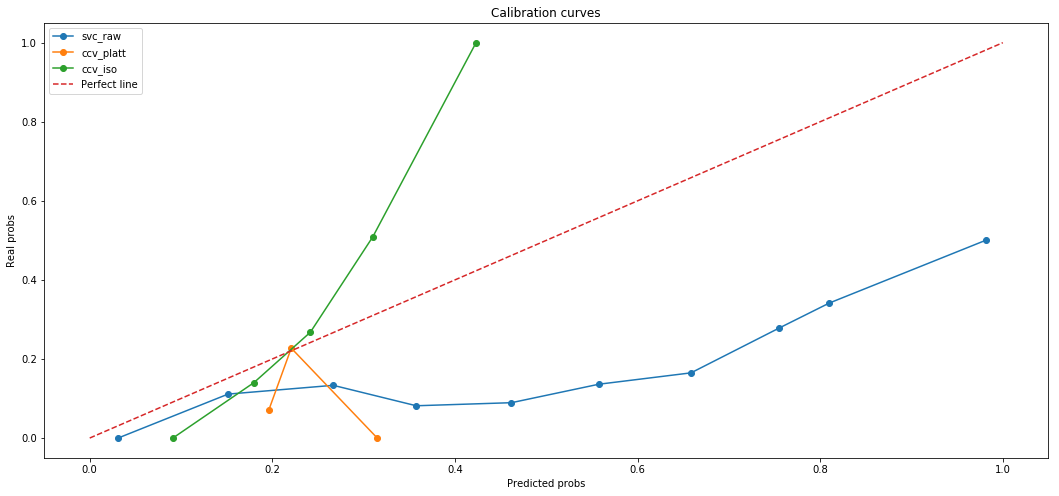

In [25]:
plt.figure(figsize=(18,8))
models = {
    "svc_raw": svc_raw, 
    "ccv_platt": calibr_cv_platt, 
    "ccv_iso": calibr_cv_iso
}

for model_type in models:
    model = models[model_type]
    model.fit(X_train, y_train)
    
    if hasattr(model, "predict_proba"):
        pred_pos = model.predict_proba(X_test)[:, 1]
    else:
        dec_f = model.decision_function(X_test)
        pred_pos = (dec_f - dec_f.min()) / (dec_f.max() - dec_f.min())
        
    true_pos, pred_pos = calibration_curve(y_test, pred_pos, n_bins=10)
    plt.plot(pred_pos, true_pos, "-o", label=model_type)

plt.plot([0,1], [0,1], "--", label="Perfect line")
plt.legend()
plt.xlabel("Predicted probs")
plt.ylabel("Real probs")
plt.title("Calibration curves")
plt.show()

**(5 баллов) Задание 4.**
 - Посчитайте `log-loss` на тестовой выборке для исходного и классификатора после калибровки.

In [26]:
from sklearn.metrics import log_loss

In [27]:
for model_type in models:
    model = models[model_type]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss = log_loss(y_test, y_pred)
    print("Model: {}, log-loss: {:.5f}".format(model_type.upper(), loss))

Model: SVC_RAW, log-loss: 21.63327
Model: CCV_PLATT, log-loss: 7.77122
Model: CCV_ISO, log-loss: 7.77122


- Дает ли калибровка прирост качества относительно метрики `log-loss`?

_Да, однозначно._

- Какой из способов калибровки в данном случае работает лучше?

_Примерно одинаково._

- Какой из подходов (калибровка на отложенной выборке или по кросс-валидации) дает более хороший результат? Свой ответ подкрепите экспериментом.

_Попробуем откалиброваться на отложенной выборке в 1/3._

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=int(0.33 * X.shape[0]), random_state=1968)

svc_raw.fit(X_train, y_train)
calibr_cv_platt = CalibratedClassifierCV(base_estimator=svc_raw, method="sigmoid", cv="prefit")
calibr_cv_iso = CalibratedClassifierCV(base_estimator=svc_raw, method="isotonic", cv="prefit")

In [29]:
def log_loss_calibr(calibr_cv, X_val, y_val):
    calibr_cv.fit(X_val, y_val)
    y_pred = calibr_cv.predict(X_test)
    return log_loss(y_test, y_pred)

In [30]:
log_loss_iso = log_loss_calibr(calibr_cv_iso, X_val, y_val)
log_loss_platt = log_loss_calibr(calibr_cv_platt, X_val, y_val)

print("Log-loss metric:\n\t- isotonic: {:.5f}\n\t- Platt: {:.5f}".format(log_loss_iso,
                                                                        log_loss_platt))

Log-loss metric:
	- isotonic: 7.73669
	- Platt: 7.77122


_Как видно, разница между отложенной выборкой и кросс-валидацией не сильная (7.77 у кросс-валидации и 7.76 у отложенной выборки)._

- Почему калибровка практически не должна повлиять на `ROC-AUC`? 

_Если мы считаем, что калибровка — это монотонное преобразование, то оно не влияет на ROC-AUC._

## 3. (8 баллов)  Работа с текстовыми данными

В остальной части задания мы будем работать с подмножеством датасета IMDB Movies Reviews из соревнования [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data). 
![](./static/popcorn.png)

Задача состоит в следующем: по отзыву на фильм необходимо понять является ли он положительным или отрицательным. Это один из примеров задачи анализа тональности текста ([sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis)). Пример отзыва из выборки:
    
> _This can be one of the most enjoyable movies ever if you don't take it seriously. It is a bit dated and the effects are lame, but it is so enjoyable. There are giant crabs that attack a girl. oh, and the crabs sing Japanese. It is amazingly bad. And the ending, which has been telegraphed throughout the entire film is hideously awesome. Predictable, but seeing the final fight will leave you rolling in your seat. Don't even give this film a chance and you will love it. Susan George is fun to watch and yes, she does appear naked. Her daughter isn't quite worth putting up with, but she does get attacked by giant crabs. They are the size of large cats. This is a 2, but I love it. As a movie, my God, but for entertainment, I give it a 7. Did I mention there are giant crabs?_

Загрузите датасет из файла `feedback_data.tsv`.

In [31]:
df = pd.read_csv("./data/feedback_data.tsv", sep="\t", encoding="utf-8")
df.head()

,id,sentiment,review
0,6678_2,0,"This is a copy of the 1948 Doris Day classic, ..."
1,11589_3,0,Bottom-of-the-Freddy barrel. This is the worst...
2,6760_2,0,Renown writer Mark Redfield (as Edgar Allen Po...
3,1150_4,0,Although there are some snippets in this 4-par...
4,11913_4,0,"A good idea, badly implemented. While that cou..."


Для оценивания качества в данной задаче мы будем использовать отложенную выборку. Разделите все данные на две части: 16000 объектов будут в обучающей выборке и 4000 объектов — в тестовой.

При разбиении выборки на две части, необходимо будет учесть следующие особенности разбиения:
 - разбиение должно быть воспроизводимо;
 - соотношение классов в каждой из частей должно сохраняться (например, при использовании функции *train_test_split* указать *stratify*).

In [32]:
X = df["review"].values
y = df["sentiment"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=1968)

Одна из сложностей данной задачи — текстовое представление данных, так как не существует какого-то универсального способа извлечения признаков из текстов. По ходу работы мы получим несколько наборов признаков, которые будем сравнивать между собой.

### 3.1 &emsp; Bag-of-words

Для начала попробуем самый простой подход, а именно [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) кодирование данных. С помощью него каждый текст будет представлен в виде вектора, размер которого равен размеру словаря, а на каждой позиции стоит число, сколько раз соответствующее слово встретилось в этом тексте. Для данного подхода хорошей практикой является фильтрация стоп-слов.

Такое представление можно получить используя класс [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) из библиотеки sklearn. Одно из удобств данного метода состоит в том, что возвращаемый результат является [sparse](http://docs.scipy.org/doc/scipy-0.15.1/reference/sparse.html)-матрицей, так как при таком преобразовании получается достаточно много нулей. Более подробно про такие матрицы было рассказано на [семинаре](https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/xswzs2g414wggh9/seminar_8.ipynb), также про это можно прочитать, например, [здесь](http://www.scipy-lectures.org/advanced/scipy_sparse/index.html).

Примените *bag-of-words* кодирование данных. Мы рекомендуем здесь и в дальнейшем обучать преобразование на обучающей выборке, после чего применять его к тестовой. Какой размерности стали данные?

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
count_vect = CountVectorizer(stop_words="english")
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)
print("Новая размерность train: {}".format(X_train.shape))
print("Новая размерность test: {}".format(X_test.shape))

Новая размерность train: (16000, 62144)
Новая размерность test: (4000, 62144)


**(2 балла) Задание 5.**

Какие недостатки для данной задачи вы видите у метрики `Accuracy`?

_Использование одной лишь `Accuracy` может оказаться неифнормативным; если, например, использовать её на датасете с явным перевесом какого-то класса (как у нас), может оказаться, что при высокой `Accuracy` окажется очень низкий `Recall`. Получается, что тогда классификатор очень плохой, но по одной из метрик он выглядит хорошим._

Обучите логистическую регрессию и случайный лес с 500 деревьев на *bag-of-words* представлении выборки и измерьте качество на тестовых данных с помощью трех описанных выше метрик: `Accuracy`, `Precision`, `Recall`. Кроме того, сравните **время** обучения алгоритмов.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [36]:
logreg = LogisticRegression(n_jobs=-1)
forest = RandomForestClassifier(n_estimators=500, random_state=1968, n_jobs=-1)

In [37]:
def train_model(model, X_train, y_train, X_test, y_test):
    %time model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    print("Accuracy: {:.5f}\nPrecision: {:.5f}\nRecall: {:.5f}".format(acc, prec, rec))
    return model

In [38]:
logreg = train_model(logreg, X_train, y_train, X_test, y_test)

CPU times: user 4.97 s, sys: 110 ms, total: 5.07 s
Wall time: 2.66 s
Accuracy: 0.87600
Precision: 0.83965
Recall: 0.82733


In [39]:
forest = train_model(forest, X_train, y_train, X_test, y_test)

CPU times: user 5min 20s, sys: 3.03 s, total: 5min 23s
Wall time: 1min 33s
Accuracy: 0.83000
Precision: 0.89806
Recall: 0.61667


Есть ли существенная разница в качестве предсказаний данных алгоритмов? Какой из методов кажется менее применимым в данной задаче и почему?

_В целом кажется, что разница есть; при схожих результатах логистическая регрессия быстрее обучается и даёт лучшее значение полноты._

Посмотрев на указанные метрики, можно понять, что классификаторы неплохо справляются с нулевым классом и похуже — с первым. Скорее всего, это является следствием того, что положительных отзывов почти вдвое меньше чем отрицательных. В дальнейшем нас будет интересовать как классификатор справляется именно с положительными отзывами (то есть с первым классом).

**(2 балла) Задание 6.**

Постройте `Precision-Recall` и `ROC` кривые обученных выше классификаторов (каждый тип кривой на отдельном графике), а также вычислите площадь под ними. Для этого удобно воспользоваться функциями [precision_recall_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html), [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) и [auc](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc). Не забудьте, что в данном случае необходимо использовать метод *predict_proba* для получения оценки принадлежности к первому классу.

In [40]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

_6.1 &emsp; Функции для каждой кривой_

In [41]:
def plot_prec_rec(y_test, y_pred):
    # данные
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # рисуем графики
    plt.step(recall, precision, color="b", alpha=0.2, where="post", label="Precision-Recall кривая")
    plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
    # оформление
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title("Кривая Precision-Recall", fontsize=16)
    plt.legend(loc="best", fontsize=12)

In [42]:
def plot_roc(y_test, y_pred):
    # данные
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    # рисуем кривую
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    # оформление
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positives", fontsize=12)
    plt.ylabel("True Positives", fontsize=12)
    rocauc_score = auc(fpr, tpr)
    plt.title("Кривая ROC; значение ROC-AUC: {:.3f}".format(rocauc_score), fontsize=16)
    plt.legend(loc="best", fontsize=12)

_6.2 &emsp; Собираем всё вместе_

In [71]:
def total_plots(model, X_test, y_test):
    plt.figure(figsize=(18,8))
    y_pred = model.predict(X_test)
    y_proba_pos = model.predict_proba(X_test)[:,1]
    plt.subplot(1, 2, 1)
    plot_prec_rec(y_test, y_proba_pos)
    plt.subplot(1, 2, 2)
    plot_roc(y_test, y_pred)

_6.3.1 &emsp; Результаты для логистической регрессии_

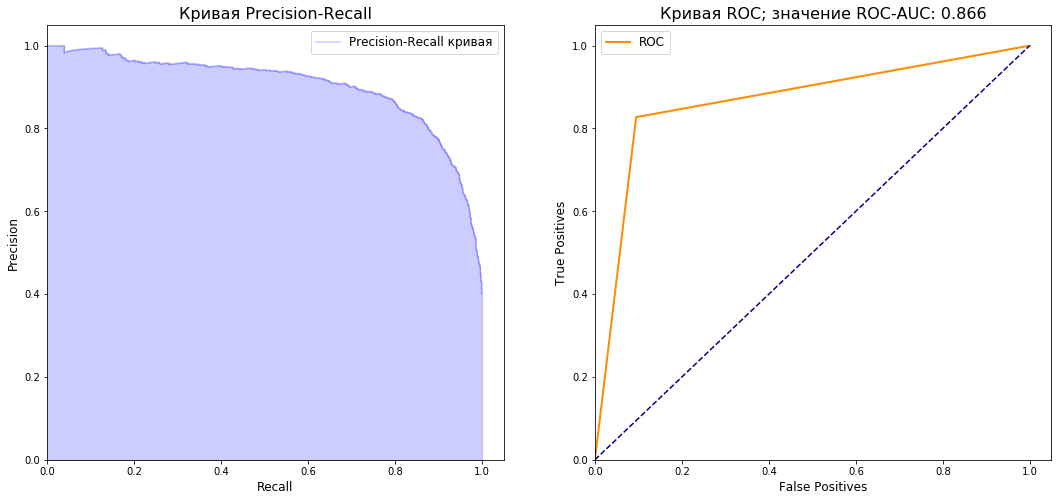

In [44]:
total_plots(logreg, X_test)

_6.3.2 &emsp; Результаты для случайного леса_

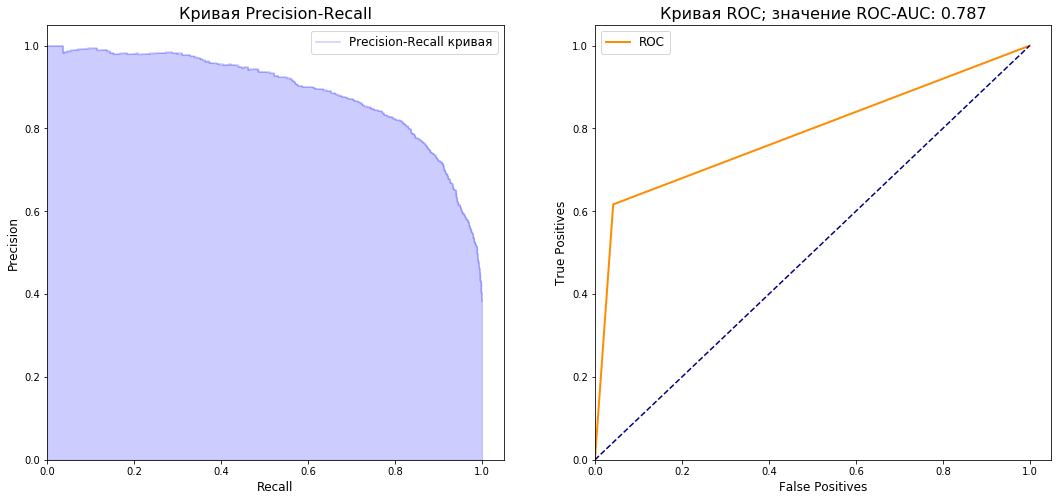

In [45]:
total_plots(forest, X_test)

Если мы хотим, чтобы классификатор находил, например, не менее 80% положительных отзывов, то необходимо потребовать, чтобы полнота была не менее 0.8. 

**(2 балла) Задание 7.**

Найдите наибольшую точность, которую будет иметь каждый классификатор при полноте не менее 0.8.

In [46]:
def find_precision(y_pred, y_test, recall_value):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    found = False
    i = 0
    best_precision = 0
    
    while not found and (i < len(recall)-1):
        if recall[i+1] < recall_value:
            found = True
            best_precision = precision[i]
        else:
            i += 1
    
    return best_precision

_Результат у логистической регрессии:_

In [47]:
y_pred_logreg = logreg.predict_proba(X_test)[:,1]
find_precision(y_pred_logreg, y_test, recall_value=0.8)

0.8639308855291576

_Результат у случайного леса:_

In [48]:
y_pred_forest = forest.predict_proba(X_test)[:,1]
find_precision(y_pred_forest, y_test, recall_value=0.8)

0.8222829801777171

В дальнейшем для экспериментов будем использовать логистическую регрессию. Можно заметить, что по некоторым причинам мы не находили оптимальные параметры для алгоритмов, а работали с параметрами по умолчанию. Чтобы исправить этот недостаток, в оставшейся части работы используйте понравившийся вам метод поиска гиперпараметров (из описанных выше) для нахождения наилучшего значения параметра *C* у логистической регрессии.

А теперь вернемся к исходной задаче. На данном этапе решения можно прийти к выводу, что предложенное кодирование текста может быть не самым удачным из-за большой матрицы объект-признак. Это ведет к ситуации, что не всякий алгоритм может быть применен в данной задаче по причине слишком большого признакового пространства, а кроме того, даже быстрые алгоритмы при наличии кросс-валидации могут начать работать медленно. Также в данных может быть шум, так как в качестве словаря были взяты все слова, даже те, которые встречались в одном-двух отзывах (например, опечатки). Поэтому кажется что неплохо было бы сократить размерность данных и по возможности избавиться от шума. 

## 4. (8 баллов) Отбор признаков и уменьшение размерности

### 4.1 &emsp; По частоте
Попробуем сформировать выборку, в которой будут находиться только самые "важные" признаки, то есть в данном случае слова. Например, это можно сделать оставив топ слов по частоте (не считая стоп-слов вроде "a", "the", "it", ...). Кажется, что вхождение наиболее частых слов в отзыве, например, *good*, *bad* и т.д. являются вполне неплохими показателями.

### 4.2  &emsp; С помощью машинного обучения
Другой подход — воспользоваться имеющимися методами машинного обучения, а именно обученным на всех признаках случайным лесом. С помощью сдучайного леса есть возможность оценивать важность признаков. То есть можно выбрать топ слов, важных как признаки для задачи классификации. 

### 4.3  &emsp; Hashing trick
Какие еще могут быть способы работы с такого рода данными? По факту слова в текстах — это некоторое очень разреженное представление (как мы убедились выше). Подходом, отличным от двух вышеперечисленных, является [хэширование](https://en.wikipedia.org/wiki/Feature_hashing) или hashing trick: каждому слову сопоставляется некоторый хэш, после чего делается, например, bag-of-words. Плюсом этого способа является возможность обрабатывать не встречавшиеся ранее слова. Этот подход реализован в классе [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html). Кроме того, если выставить параметр *non_negative=True*, то можно интерпретировать полученные значения как некоторые "частоты".

Заметьте, что два последних подхода можно применять не обязательно к текстовым данным.

**(4 балла) Задание 8.**

Сформируйте три новые выборки, где каждый объект будет иметь 15000 признаков, следующим образом:
 - топ самых частотных слов
 - топ наиболее "важных" слов с помощью случайного леса
 - с помощью хэширования
 
Для последних двух выборок не забывайте фильтровать стоп-слова, для этого можно использовать параметр stop_words='english' у классов CountVectorizer, HashingVectorizer.

На четырех выборках (*bag-of-words* и трех новых) постройте *ROC* кривые, вычислив площадь под ними.

In [49]:
X_train_text, X_test_text, y_train_text, y_train_text = train_test_split(X, y,
    stratify=y, train_size=0.8, random_state=1968)

_8.1 &emsp; Топ самых частотных слов_

In [50]:
count_vect1 = CountVectorizer(max_features=15000)

X_train1 = count_vect1.fit_transform(X_train_text)
X_test1 = count_vect1.transform(X_test_text)

_8.2 &emsp; Топ самых "важных" слов у Random Forest_

In [53]:
count_vect2 = CountVectorizer(stop_words="english")
forest2 = RandomForestClassifier(n_estimators=500)

X_train2 = count_vect2.fit_transform(X_train_text)
X_test2 = count_vect2.transform(X_test_text)

forest2.fit(X_train2, y_train);

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [54]:
imp_feat = forest.feature_importances_
names = count_vect2.get_feature_names()

best_features = sorted(zip(names, imp_feat), key=lambda x: x[1], reverse=True)[:15000]
best_features = [elem[0] for elem in best_features]

In [55]:
count_vect2 = CountVectorizer(vocabulary=best_features)
X_train2 = count_vect2.fit_transform(X_train_text)
X_test2 = count_vect2.transform(X_test_text)

_8.3 &emsp; Hashing trick_

In [56]:
from sklearn.feature_extraction.text import HashingVectorizer

In [57]:
count_vect3 = HashingVectorizer(stop_words="english", n_features=15000)

X_train3 = count_vect3.fit_transform(X_train_text)
X_test3 = count_vect3.transform(X_test_text)

Что вы можете сказать о качестве этих подходов к сокращению размерности?
Выведите топ-20 самых важных слов от случайного леса и сравните их с топ-20 наиболее частотных. Много ли общих слов?

In [59]:
vect1_freqs = np.asarray(X_train1.sum(axis=0))
freqs = [(i, freq) for i, freq in enumerate(vect1_freqs[0])]
freqs = sorted(freqs, key=lambda x : x[1], reverse=True)[:20]
names = vect1.get_feature_names()

most_frequent_20 = [names[freqs[i][0]] for i in range(len(freqs))]
best_features_20 = best_features[:20]

pd.DataFrame(data={"Самые частотные слова": most_frequent_20, "Best RF features": best_features_20})

,Самые частотные слова,Best RF features
0,the,bad
1,and,worst
2,of,great
3,to,excellent
4,is,waste
5,br,wonderful
6,it,awful
7,in,best
8,this,perfect
9,that,terrible


_Общих слов немного, т.к. самые частотные слова — служебные, а для случайного леса имеют вес смыслонесущие слова._

_8.4 &emsp; Подбор параметров для логистической регрессии_

Будем использовать RandomizedSearchCV.

In [60]:
def quick_random_search(model, params, X_train, y_train):
    rgrid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=params,
        scoring="roc_auc", 
        n_iter=5, 
        random_state=1968,
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    rgrid.fit(X_train, y_train)
    return rgrid

Отталкиваться будем от таких параметров:

In [61]:
params = {
    "C": np.logspace(-1, 2)
}
logreg = LogisticRegression(
    n_jobs=-1, 
    random_state=1968
)

_8.4.1 &emsp; Результаты: частотные слова_

In [63]:
logreg1 = quick_random_search(logreg, params, X_train1, y_train)
print("Score: {:.5f}\nParameters: {}".format(logreg1.best_score_, logreg1.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   59.6s finished


Score: 0.94075
Parameters: {'C': 0.3088843596477481}


_8.4.2 &emsp; Результаты: слова из леса_

In [64]:
logreg2 = quick_random_search(logreg, params, X_train2, y_train)
print("Score: {:.5f}\nParameters: {}".format(logreg2.best_score_, logreg2.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   23.5s finished


Score: 0.93646
Parameters: {'C': 0.3088843596477481}


_8.4.3 &emsp; Результаты: хэшинг_

In [66]:
logreg3 = quick_random_search(logreg, params, X_train3, y_train)
print("Score: {:.5f}\nParameters: {}".format(logreg3.best_score_, logreg3.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.2s finished


Score: 0.93939
Parameters: {'C': 6.8664884500430015}


_Примерно одинаковый результат показал хэшинг и топ самых частотных слов, чуть хуже — важные слова от случайного леса. При этом случайный лес и топ частотных дал примерно одинаковое значение C, которое мы и будем считать итоговым решением._

_**8.5 &emsp; Создаём экземпляр настроенной логистической регрессии**_

In [67]:
tuned_logreg = LogisticRegression(C=0.3, random_state=1968, n_jobs=-1)

_8.5.1 &emsp; Настроенная регрессия + частотные_

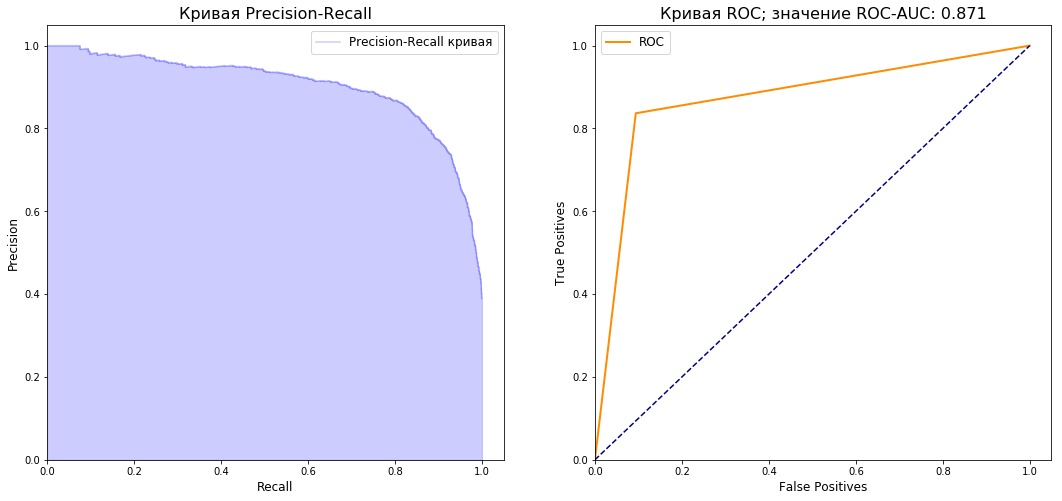

In [72]:
tuned_logreg1 = tuned_logreg.fit(X_train1, y_train)
total_plots(tuned_logreg1, X_test1, y_test)

_8.5.2 &emsp; Настроенная регрессия + слова из леса_

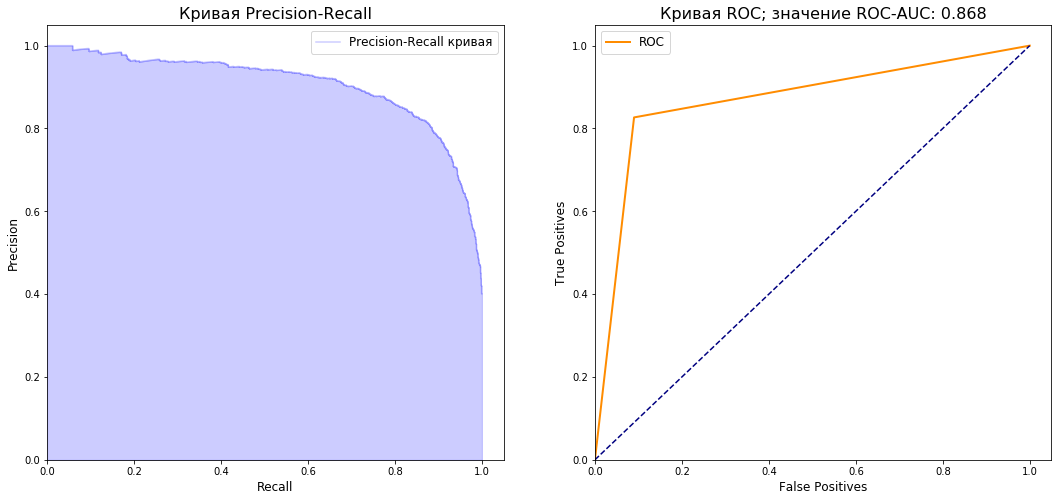

In [73]:
tuned_logreg2 = tuned_logreg.fit(X_train2, y_train)
total_plots(tuned_logreg2, X_test2, y_test)

_8.5.1 &emsp; Настроенная регрессия + частотные_

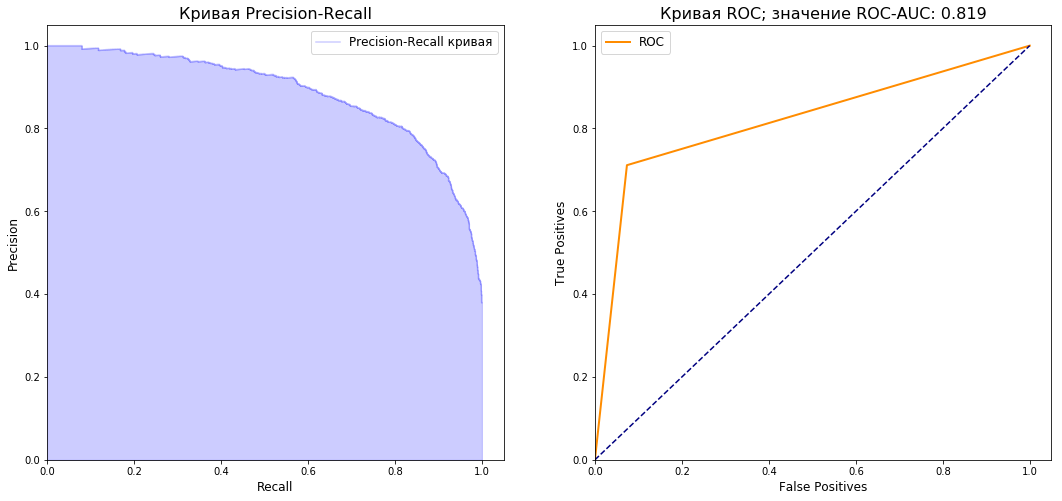

In [74]:
tuned_logreg3 = tuned_logreg.fit(X_train3, y_train)
total_plots(tuned_logreg3, X_test3, y_test)

_Итоговый вариант:_
* _C=0.3,_
* _используемые вектора — по топу важных слов от случайного леса_

Таким образом, удалось сократить размерность более чем в три раза без сильной потери в качестве. Но даже 15000 признаков — это достаточно много. Допустим, мы хотим уменьшить размерность до 2000 признаков, однако можно заметить, что даже три предыдущие способа давали небольшое ухудшение в качестве.

Одним из способов сокращения размерности является метод главных компонент ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)). Это преобразование позволяет получить вес каждого признака в компоненте. Например, если применить его к bag-of-words, можно найти наиболее важные слова, влияющие на данную компоненту. Для работы с большими разреженными матрицами в sklearn рекомендуется использовать [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

**(4 балла) Задание 9.**

Попробуйте сократить размерность до 2000 двумя способами:
 - наилучшим из трех предыдущих
 - для выборки со всеми признаками обучите *PCA*-преобразование 

Постройте новый график качества. Какой из двух подходов работает лучше?

Для первых трех компонент преобразования найдите топ-30 наиболее важных слов. Можете ли вы охарактеризовать как-то каждую из этих групп?

_9.1 &emsp; Forest v2_

In [76]:
forest_vect = CountVectorizer(
    vocabulary=best_features, 
    max_features=2000
)

X_train_forest = forest_vect.fit_transform(X_train_text)
X_test_forest = forest_vect.transform(X_test_text)

_9.2 &emsp; PCA_

In [77]:
from sklearn.decomposition import TruncatedSVD

In [81]:
lsa = TruncatedSVD(
    n_components=2000, 
    random_state=1968
)

X_train_pca = lsa.fit_transform(X_train)
X_test_pca = lsa.transform(X_test)

TypeError: __init__() got an unexpected keyword argument 'n_jobs'

_9.3 &emsp; Сравниваем результаты_

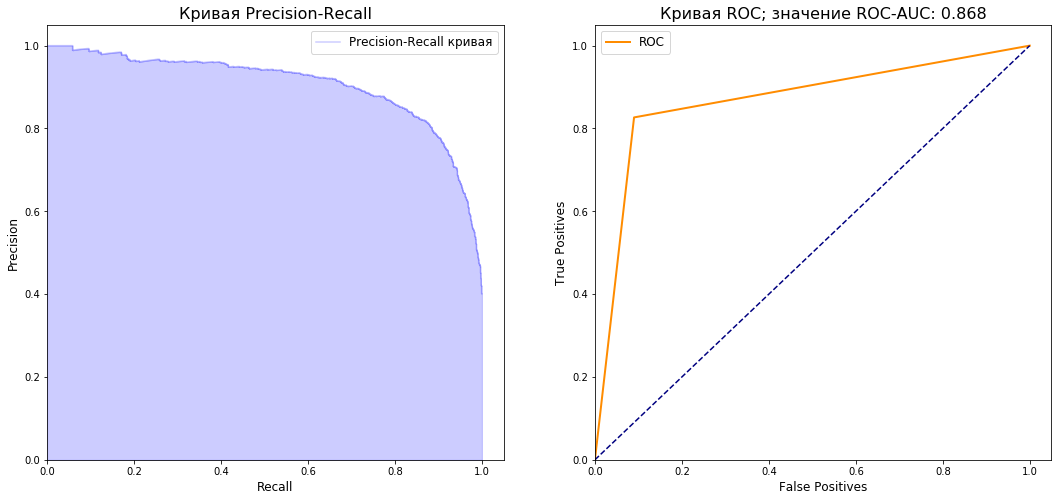

In [84]:
tuned_logreg_forest = tuned_logreg.fit(X_train_forest, y_train)
total_plots(tuned_logreg_forest, X_test_forest, y_test)

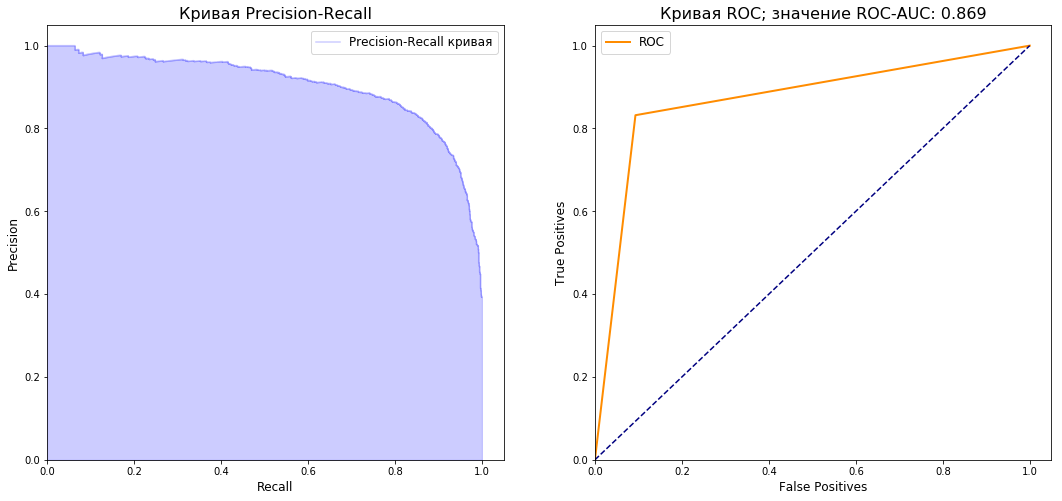

In [85]:
tuned_logreg_pca = tuned_logreg.fit(X_train_pca, y_train)
total_plots(tuned_logreg_pca, X_test_pca, y_test)

_9.5 &emsp; Компоненты_

In [86]:
feature_names = count_vect.get_feature_names()

In [90]:
best_features1 = [feature_names[i] for i in lsa.components_[0].argsort()[::-1]][:30]
print(best_features1)

['br', 'movie', 'film', 'like', 'just', 'good', 'time', 'really', 'story', 'bad', 'people', 'don', 'make', 'way', 'character', 'great', 'characters', 'think', 'films', 'movies', 'know', 'plot', 'little', 'did', 'does', 'scene', 'man', 'life', 'seen', 'watch']


_Оценочные слова._

In [91]:
best_features2 = [feature_names[i] for i in lsa.components_[1].argsort()[::-1]][:30]
print(best_features2)

['br', 'basket', 'match', 'arquette', 'milo', 'episode', 'capshaw', 'mall', 'tucci', 'security', 'season', 'wolverine', 'wwe', 'sommer', 'erika', 'edie', 'atlantis', 'crystal', 'wench', 'rourke', 'chavez', 'savalas', 'jill', 'cody', 'dalton', 'kareena', 'bronte', 'lisa', 'chikatilo', 'esther']


_Здесь про имена персонажей._

In [92]:
best_features3 = [feature_names[i] for i in lsa.components_[2].argsort()[::-1]][:30]
print(best_features3)

['film', 'films', 'director', 'man', 'story', 'character', 'work', 'young', 'characters', 'best', 'does', 'quite', 'horror', 'great', 'world', 'years', 'scene', 'life', 'cinema', 'role', 'woman', 'performance', 'time', 'way', 'new', 'screen', 'scenes', 'fact', 'john', 'doesn']


_Здесь про фильмы в общем и про связанные с ними вещи._

### Какие еще могут быть способы обработки текстовых данных?

Как можно заметить, подход с мешком слов, в котором учитывается лишь факт вхождения слова в отзыв, весьма наивен, так как не позволяет учесть информацию в скольки отзывах встречалось данное слово (например, чтобы избавиться от очень редких слов). В этом случае может помочь [tf-idf кодирование](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

Другой недостаток описанного в задании подхода заключается в использовании абсолютных частот слов. У некоторых слов они могут быть очень большими, в то же время у других — низкими. Чтобы "сгладить" разницу между ними, можно сделать логарифмирование, т.е. применить преобразование $x \to log(x + 1)$ (так как при bag-of-words кодировании могут встречаться 0).

Неплохое руководство можно найти в разделе [извлечения признаков](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) из документации sklearn.


## 5. (15 баллов) Бонусное задание. Библиотека Vowpal Wabbit. Выводы.

Еще одним подходом для работы с текстовым данными является использование библиотеки [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki).

VW представляет из себя хорошую реализация стохастического градиентного спуска для линейных моделей. К преимуществам и особенностям данной библиотеки можно отнести:
 - Считывание с диска происходит батчами, VW делает каждый следующий шаг градиентного спуска только по батчу, поэтому нет необходимости хранить всю выборку в памяти, из-за чего его удобно применять для больших выборок при ограниченных ресурсах.
 - Из коробки работают: нормализация признаков, взвешивание объектов, адаптивный градиентный шаг, матричные разложения, тематическое моделирование, активное обучение, обучение с подкреплением.
 - Реализация VW содержит различные методы оптимизации: сопряженные градиенты, квазиньютоновские методы (L-BFGS).
 - VW может быть запущен на кластере.

Перед началом работы с vw полезно будет ознакомиться с информацией по ссылкам:
 - [Туториал по VW](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial)
 - [Описание формата входных данных](https://github.com/JohnLangford/vowpal_wabbit/wiki/Input-format)
 - [Описание параметров командной строки](https://github.com/JohnLangford/vowpal_wabbit/wiki/Command-line-arguments)

Приведите обучающую и тестовую выборки к формату пригодному для обучения модели с помощью vw: в качестве признаков используйте тексты отзывов как есть. Например:

```
-1 |text_namespace This is a bad movie
 1 |text_namespace This is my favorite movie
...
```

**(9 баллов) Задание 10.**

Обучите Vowpal Wabbit на полученной выборке. В качестве функции потерь (параметр [loss_function](https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions)) попробуйте использовать:
  - логистическую (logistic)
  - кусочно-линейную (hinge)

Постройте *Precision-Recall* и *ROC* кривые для каждой из получившихся моделей. Сравните время обучения и получившееся качество со временем обучения и качеством предыдущих моделей.

**(3 балла) Задание 11.**

В первой части лабораторной работы мы рассмотрели 2 способа подбора гиперпараметров и калибровки алгоритмов машинного обучения. Ответьте на следующие вопросы:

- В каких случаях случайный поиск гиперпараметра имеет преимущество, в сравнении с перебором по сетке? Приведите пример такого случая.
- Для какого типа задач машинного обучения имеет смысл использовать калибровку предсказаний? Приведите пример такой задачи.

Приведенные примеры не должны совпадать с упомянутыми ранее в работе.

**(3 балла) Задание 12.**

В второй части лабораторной работы мы рассмотрели несколько методов работы с текстовыми данными. Ответьте на следующие вопросы:

- Какие есть достоинства у рассмотренных методов представления текстовых данных? Поясните свой ответ для каждого рассмотренного метода.

- Каким общим недостатком обладают данные методы?

- Какие модели машинного обучения больше подходят для работы с текстовыми данными на практике и почему? В чём их преимущество перед другими алгоритмами?